In [51]:
import pandapower as pp

import pandas as pd
import numpy as np
from numpy.random import default_rng
import cvxpy as cp
import networkx as nx
import mosek

from solution_files_manager import SolutionFilesManager
from opt_utils import *
from opf_utils import *

In [52]:
import os
folder = os.path.abspath(os.getcwd())

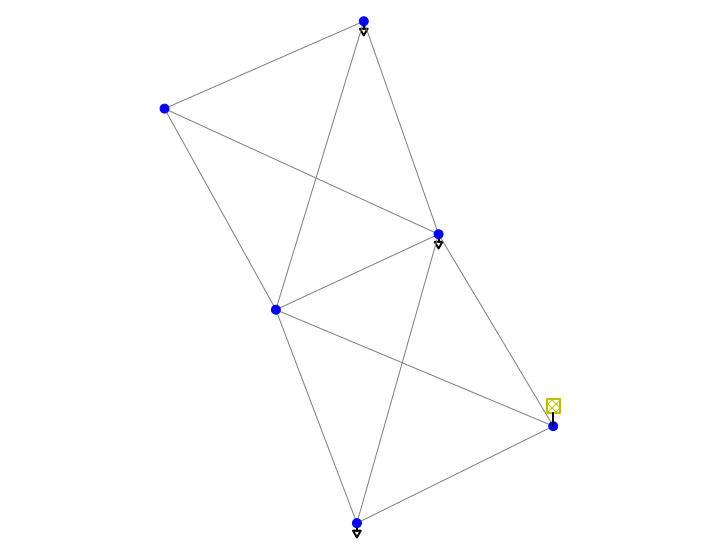

In [53]:
case = "case6ww"
net, n, gen_df, n_gen, gens, load_df, graph, G_val, B_val, Y_val = load_pp_network(case)

## Variables

In [54]:
X = cp.Variable((n,n), hermitian=True)

## Parameters

In [55]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [56]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [57]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [58]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y_val
    Phi_i = 1 / 2 * (Y_i.conj().T + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.conj().T - Y_i)
    Psis.append(Psi_i)

### Build sparsity graph

In [59]:
sparsity_graph = nx.Graph()
graph_nodes_list = sorted(graph.nodes())
# the sparsity graph of complex variables is exactly the power network
sparsity_graph.add_nodes_from(graph_nodes_list)
sparsity_graph.add_edges_from(graph.edges())

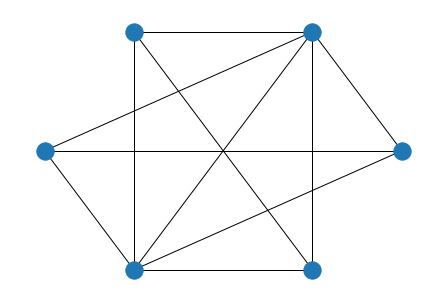

In [60]:
nx.draw(sparsity_graph, nx.circular_layout(sparsity_graph))

### Construct enriched supergraph

In [61]:
G_bar = build_enriched_supergraph(sparsity_graph)

Treewidth: 3


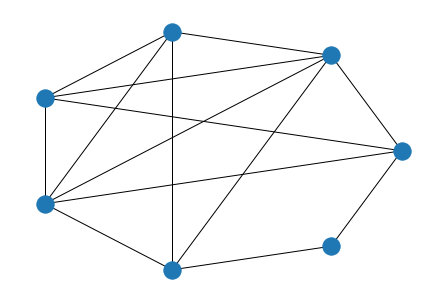

In [62]:
nx.draw(G_bar, nx.circular_layout(G_bar))

## SDP (QCQP)

In [63]:
constraints = [ X >> 0 ]

for i in range(n):
    # TODO: multiple generators at one bus
    if i in gens:
        i_gen_idx = list(gens).index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [64]:
# the power generation costs are not dpp but can be modified
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [65]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [66]:
# prob.solve(solver=cp.SCS, verbose=True)
prob.solve(solver=cp.CVXOPT, verbose=True)
# prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jun 30 12:37:37 PM: Your problem has 36 variables, 21 constraints, and 54 parameters.
(CVXPY) Jun 30 12:37:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 30 12:37:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 30 12:37:37 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Jun 30 12:37:37 PM: Reduction chain: EvalParams -> Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CVXOPT
(CVXPY) Jun 30 12:37:37 PM: Applying reduction EvalParams
(CVXPY) Jun 30 12:37:37 PM: Appl

/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


SolverError: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
np.linalg.eigvalsh(X.value)

In [284]:
X_ref_val = X.value

In [285]:
recover_verify_solution(prob, X, 1)

6.3415981998256135e-15
[0.]
[0.]
[0.]
[0.]
[1.25377122e-07]
[7.75807718e-08]
[4.4870507e-08]
[2.35165838e-08]
[3.55926377e-08]
[1.70245356e-08]
[2.03355694e-08]
[1.36100161e-08]
[3.26648719e-08]
[4.09147873e-08]
[1.16659873e-08]
[1.44326966e-08]
[1.64162199e-08]
[6.30961571e-09]
[9.70130264e-09]
[3.64974073e-09]
[4.05992357e-08]
[9.52278545e-09]
[4.85472887e-08]
[1.25879181e-08]
[1.52839694e-08]
[1.46660841e-08]
[1.06537689e-09]
[4.71791289e-09]
[4.1184287e-09]
[5.99073945e-09]
[1.72804355e-08]
[1.01959415e-08]
[2.56682448e-10]
[3.27083582e-09]
[4.59942861e-09]
[8.64167293e-09]
[8.27758341e-09]
[9.71521971e-10]
[3.06507243e-08]
[3.07551802e-08]
[7.74131836e-09]
[1.18339547e-08]
[9.81964165e-09]
[1.15388112e-08]
[7.49221471e-10]
[1.6058137e-09]
[1.59388677e-08]
[1.58856867e-08]
[4.4138055e-09]
[5.45216626e-09]
[1.60938637e-10]
[8.4238792e-10]
[3.64030332e-08]
[4.74701572e-09]
[1.75497374e-08]
[1.14292438e-08]
[1.19805106e-08]
[4.58963378e-09]
[2.07664237e-08]
[8.72133509e-09]
[1.3177499

In [286]:
recover_verify_solution(prob, X, 2)

7.763394859438281e-15
[0.]
[0.]
[0.]
[0.]
[1.2956958e-07]
[8.94165131e-08]
[4.65441016e-08]
[2.8739215e-08]
[3.62777643e-08]
[1.91332559e-08]
[2.27234069e-08]
[1.33987167e-08]
[3.3637163e-08]
[4.03834204e-08]
[9.49181754e-09]
[1.59696787e-08]
[1.66359872e-08]
[6.68820176e-09]
[1.03239095e-08]
[3.86983978e-09]
[4.29675102e-08]
[7.96759214e-09]
[4.51716103e-08]
[3.68851427e-09]
[1.92273271e-08]
[2.51749725e-08]
[6.17848772e-09]
[3.76447689e-09]
[1.06220299e-08]
[9.6661985e-09]
[1.41581979e-08]
[5.01890585e-09]
[4.34680913e-09]
[9.2197332e-09]
[2.75238676e-09]
[2.51287635e-09]
[2.70082746e-09]
[6.27516661e-09]
[3.13769238e-08]
[3.056565e-08]
[1.10956823e-08]
[1.25764417e-08]
[1.32784482e-08]
[1.52909814e-08]
[3.22537518e-09]
[2.96211455e-09]
[1.80520395e-08]
[1.23546836e-08]
[1.03484956e-08]
[7.44986515e-09]
[4.21334186e-09]
[2.57362085e-09]
[4.34590388e-08]
[1.38725054e-08]
[1.98527912e-08]
[1.2800618e-08]
[1.08724645e-08]
[5.24504107e-09]
[2.00895074e-08]
[9.58835799e-09]
[1.32139428e-0

### Interior point computation

In [ ]:
X_ac = cp.Variable((n,n), hermitian=True)

In [ ]:
prob_ac = cp.Problem(cp.Maximize(cp.log_det(X_ac) \
                              + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[i] @ X_ac)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[i] @ X_ac)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(q_max[i] - cp.real(cp.trace(Psis[i] @ X_ac)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[i] @ X_ac)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ]) \
                              + cp.sum([ cp.log(V_max_sq[i] - cp.real(X_ac[i][i])) + cp.log(cp.real(X_ac[i][i]) - V_min_sq[i]) for i in range(n) ]) ))

# prob_ac.solve(solver=cp.SCS, verbose=True)
prob.solve(solver=cp.MOSEK, verbose=True)

### Fixed point iterations

In [298]:
fixed_point_iteration(prob, X, -X_ac.value, True)

TypeError: bad operand type for unary -: 'NoneType'

In [299]:
recover_verify_solution(prob, X, 1)

6.3415981998256135e-15
[0.]
[0.]
[0.]
[0.]
[1.25377122e-07]
[7.75807718e-08]
[4.4870507e-08]
[2.35165838e-08]
[3.55926377e-08]
[1.70245356e-08]
[2.03355694e-08]
[1.36100161e-08]
[3.26648719e-08]
[4.09147873e-08]
[1.16659873e-08]
[1.44326966e-08]
[1.64162199e-08]
[6.30961571e-09]
[9.70130264e-09]
[3.64974073e-09]
[4.05992357e-08]
[9.52278545e-09]
[4.85472887e-08]
[1.25879181e-08]
[1.52839694e-08]
[1.46660841e-08]
[1.06537689e-09]
[4.71791289e-09]
[4.1184287e-09]
[5.99073945e-09]
[1.72804355e-08]
[1.01959415e-08]
[2.56682448e-10]
[3.27083582e-09]
[4.59942861e-09]
[8.64167293e-09]
[8.27758341e-09]
[9.71521971e-10]
[3.06507243e-08]
[3.07551802e-08]
[7.74131836e-09]
[1.18339547e-08]
[9.81964165e-09]
[1.15388112e-08]
[7.49221471e-10]
[1.6058137e-09]
[1.59388677e-08]
[1.58856867e-08]
[4.4138055e-09]
[5.45216626e-09]
[1.60938637e-10]
[8.4238792e-10]
[3.64030332e-08]
[4.74701572e-09]
[1.75497374e-08]
[1.14292438e-08]
[1.19805106e-08]
[4.58963378e-09]
[2.07664237e-08]
[8.72133509e-09]
[1.3177499

In [ ]:
recover_verify_solution(prob, X, 2)

### Hyperplane rounding

In [ ]:
def cost_from_exact_solution(v):
    X_exact = np.outer(v, v.conj())
    p_g, q_g = compute_generation(X_exact, n_gen, p_d_val, q_d_val, G_val, B_val, graph)
    p_cost = np.sum(c_p_2.value @ np.square(p_g) + c_p_1.value @ p_g + np.sum(c_p_0.value))
    q_cost = np.sum(c_q_2.value @ np.square(q_g) + c_q_1.value @ q_g + np.sum(c_q_0.value))
    return p_cost + q_cost

In [ ]:
# note that this usually results in an infeasible point
hyperplane_cost, hyperplane_v = complex_hyperplane_rounding(decompose_psd(X.value), cost_from_exact_solution, net.bus["min_vm_pu"].to_numpy(), net.bus["max_vm_pu"].to_numpy())
print(hyperplane_cost)

In [ ]:
check_power_feasibility(np.outer(hyperplane_v, hyperplane_v.conj()), p_min.value, p_max.value, q_min.value, q_max.value, gens, n_gen, p_d_val, q_d_val, G_val, B_val, graph)

In [ ]:
# sfm = SolutionFilesManager(folder, case, "orig")
# a = sfm.load_solution()
# v = a[1]
# X_val = np.outer(v, v.conj())
# X.value = X_val
#
# for c in prob.constraints:
#     print(c.violation())

In [ ]:
# sfm = SolutionFilesManager(folder, case, "sdp")
# sfm.save_solution(prob.value, X.value, None, None)